In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/data/*.zip .
!unzip /content/sudoku.zip
!mkdir /content/test
!unzip /content/sudoku_test.zip -d /content/test
!mv /content/test/sudoku.csv /content/sudoku_test.csv

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/sudoku.zip
replace sudoku.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
mkdir: cannot create directory ‘/content/test’: File exists
Archive:  /content/sudoku_test.zip
  inflating: /content/test/sudoku.csv  


In [10]:
!rm -rf drl-sudoku
!git clone https://github.com/cloughurd/drl-sudoku.git
!mv drl-sudoku/rl/* .

Cloning into 'drl-sudoku'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 287 (delta 179), reused 122 (delta 55), pack-reused 0
Receiving objects: 100% (287/287), 424.18 KiB | 488.00 KiB/s, done.
Resolving deltas: 100% (179/179), done.
mv: cannot move 'drl-sudoku/rl/env' to './env': Directory not empty


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json

assert torch.cuda.is_available()
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

from env.SisypheanGrid import SisypheanGrid
from helpers import prepare_batch, learn_dqn, get_action_dqn
from qnetwork import QNetwork

Loading grid.
Loaded grid.


Episodes: 0 Reward: -50 Epsilon: 0.9948 Positive Reward Count: 1:   0%|          | 1/50000 [00:00<2:52:58,  4.82it/s]


Epoch 0


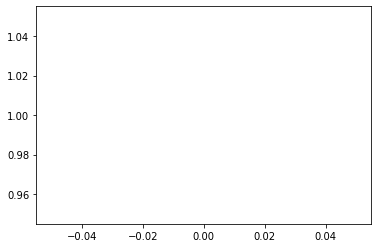

Episodes: 10 Reward: -50 Epsilon: 0.9386 Positive Reward Count: 2:   0%|          | 11/50000 [00:03<3:55:22,  3.54it/s]


Epoch 10


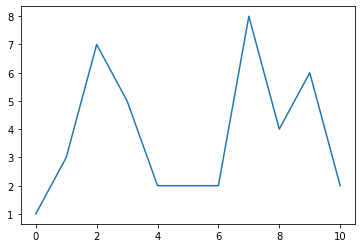

Episodes: 20 Reward: -50 Epsilon: 0.8876 Positive Reward Count: 4:   0%|          | 21/50000 [00:15<30:52:13,  2.22s/it]


Epoch 20


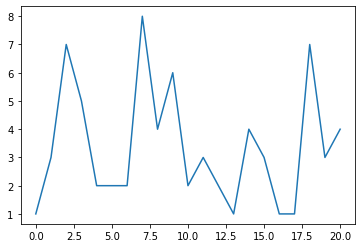

Episodes: 30 Reward: -50 Epsilon: 0.8415 Positive Reward Count: 1:   0%|          | 31/50000 [00:44<39:48:18,  2.87s/it]


Epoch 30


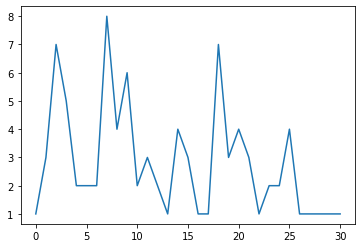

Episodes: 40 Reward: -50 Epsilon: 0.7947 Positive Reward Count: 2:   0%|          | 41/50000 [01:15<42:20:45,  3.05s/it]


Epoch 40


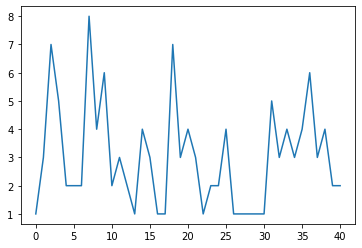

Episodes: 50 Reward: -50 Epsilon: 0.7525 Positive Reward Count: 0:   0%|          | 51/50000 [01:45<41:41:33,  3.00s/it]


Epoch 50


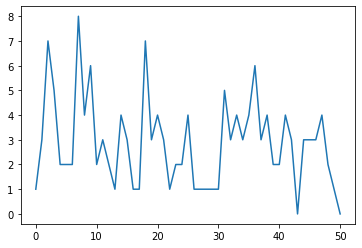

Episodes: 60 Reward: -50 Epsilon: 0.7113 Positive Reward Count: 6:   0%|          | 61/50000 [02:16<44:50:35,  3.23s/it]


Epoch 60


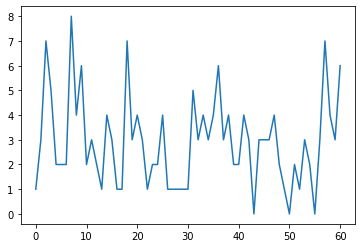

Episodes: 70 Reward: -50 Epsilon: 0.6719 Positive Reward Count: 3:   0%|          | 71/50000 [02:50<46:28:40,  3.35s/it]


Epoch 70


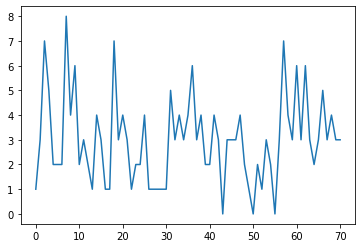

Episodes: 80 Reward: -50 Epsilon: 0.6354 Positive Reward Count: 2:   0%|          | 81/50000 [03:24<47:17:23,  3.41s/it]


Epoch 80


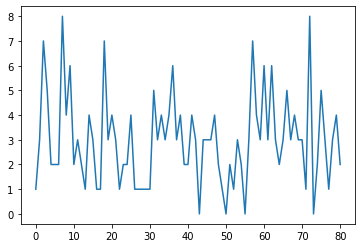

Episodes: 90 Reward: -50 Epsilon: 0.6019 Positive Reward Count: 1:   0%|          | 91/50000 [03:57<45:39:35,  3.29s/it]


Epoch 90


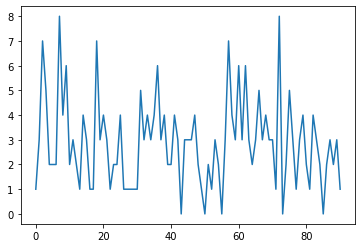

Episodes: 100 Reward: -50 Epsilon: 0.5695 Positive Reward Count: 1:   0%|          | 101/50000 [04:33<49:11:31,  3.55s/it]


Epoch 100


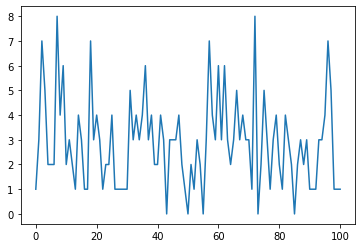

Episodes: 110 Reward: -50 Epsilon: 0.5398 Positive Reward Count: 0:   0%|          | 111/50000 [05:09<50:22:05,  3.63s/it]


Epoch 110


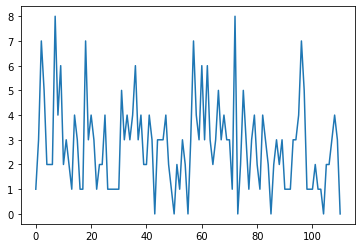

Episodes: 120 Reward: -50 Epsilon: 0.5108 Positive Reward Count: 0:   0%|          | 121/50000 [05:46<50:32:14,  3.65s/it]


Epoch 120


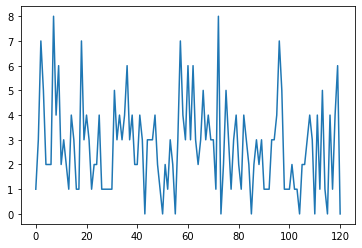

Episodes: 130 Reward: -50 Epsilon: 0.4833 Positive Reward Count: 1:   0%|          | 131/50000 [06:25<50:50:22,  3.67s/it]


Epoch 130


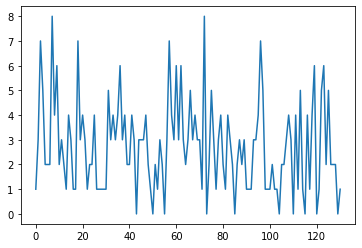

Episodes: 137 Reward: -50 Epsilon: 0.4650 Positive Reward Count: 2:   0%|          | 138/50000 [06:51<51:32:14,  3.72s/it]

In [0]:
def dqn_main(num_epochs=50000):
    # Hyper parameters
    lr = 1e-3
    start_training = 1000
    gamma = 0.99
    batch_size = 32
    epsilon = 1
    epsilon_decay = .9999
    target_update = 1000
    learn_frequency = 4

    # I wonder if helping the network learn on positive examples more would be better...
    # Throw some negative examples out. :)
    keep_neg_prop = 0.4

    # Init environment
    action_size = 9*81
    
    print("Loading grid.")
    env = SisypheanGrid('/content/sudoku.csv', max_len=5000000)
    print("Loaded grid.")

    # Init networks
    q_network = QNetwork(18, action_size).cuda()
    target_network = QNetwork(18, action_size).cuda()
    target_network.load_state_dict(q_network.state_dict())

    # Init optimizer
    optim = torch.optim.Adam(q_network.parameters(), lr=lr)

    # Init replay buffer
    memory = []

    total_learnings = 0

    # Begin main loop
    save_freq = 5000
    results_dqn = []
    pos_reward_counts = []

    losses = []
    reward_curves = {}
    global_step = 0
    loop = tqdm(total=num_epochs, position=0, leave=False)
    for epoch in range(num_epochs):
        # New puzzle
        state, goal = env.reset()
        done = False
        cum_reward = 0  # Track cumulative reward per episode
        rewards = []
        pos_count = 0

        # Begin episode
        while not done and abs(cum_reward) < 50:
            # Select e-greedy action
            action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

            # Take step
            next_state, reward, done = env.act(state, action, goal)
            # env.render()

            # Store step in replay buffer
            memory.append((state, action, next_state, reward, done))

            if reward >= 0:
              pos_count += 1
              memory.append((state, action, next_state, reward, done))
            else:
              if random.random() < keep_neg_prop:
                memory.append((state, action, next_state, reward, done))
            
            cum_reward += reward
            rewards.append(reward)
            global_step += 1  # Increment total steps
            state = next_state  # Set current state

            # If time to train
            if global_step > start_training and global_step % learn_frequency == 0:
                total_learnings += 1

                # Sample batch
                batch = prepare_batch(memory, batch_size)

                # Train
                loss = learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
                losses.append((global_step, loss))

        # Print results at end of episode
        results_dqn.append(cum_reward)
        pos_reward_counts.append(pos_count)
        reward_curves[epoch] = rewards
        loop.update(1)
        loop.set_description('Episodes: {} Reward: {} Epsilon: {:.4f} Positive Reward Count: {}'.format(epoch, cum_reward, epsilon, pos_count))
        
        if epoch % 10 == 0:
          print(f"\nEpoch {epoch}")
          plt.plot(pos_reward_counts)
          plt.show()

        if epoch+1 % save_freq == 0:
            torch.save(q_network.state_dict(), model_dir + f'rl-{epoch}.mod')
            json.dump({'rewards': reward_curves, 'loss': losses},
                      open(model_dir + f'rl-results-{epoch}.json', 'w'))

    print(total_learnings)
    return results_dqn, pos_reward_counts

results_dqn = dqn_main()

In [0]:
plt.plot(results_dqn)
plt.show()